In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from typing import List
from skimage.filters import threshold_multiotsu



<h2>Load Image</h2>

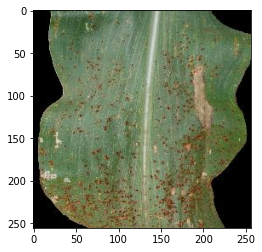

In [212]:
imageNo = 900

imagePath = f'../../rust/corn_common_rust/{imageNo}.jpg'

image = cv2.cvtColor(cv2.imread(imagePath), cv2.COLOR_BGR2RGB)

plt.imshow(image)

<h2> Visualize all r. g and b channels </h2>

In [213]:
#function to show multiple images and their r,g and b channels in grayscale
def show_image_grid(imagePaths : List[str]) -> None:
    
    n:int = len(imagePaths)
    
    #load figure
    fig, axs = plt.subplots(n, 4)
    
    fig.set_figheight(20)
    fig.set_figwidth(15)
    for x in range(n):
        image = cv2.cvtColor(cv2.imread(imagePaths[x]), cv2.COLOR_BGR2RGB)
        #gaussian blur
        image = cv2.GaussianBlur(image, (7, 7), 2)
        #get channels
        r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
        #original image
        axs[x, 0].imshow(image)
        axs[x, 0].title.set_text('Original Image')
        #r channel
        axs[x, 1].imshow(r, cmap = 'gray', vmin = 0, vmax = 255)
        axs[x, 1].title.set_text('R channel')
        #g channel
        axs[x, 2].imshow(g, cmap = 'gray', vmin = 0, vmax = 255)
        axs[x, 2].title.set_text('G channel')
        # bchannel
        axs[x, 3].imshow(b, cmap = 'gray', vmin = 0, vmax = 255)
        axs[x, 3].title.set_text('B channel')

        

<h2> Smoothen Image </h2>

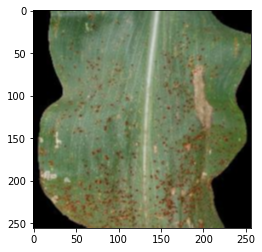

In [214]:
smooth = cv2.GaussianBlur(image, (3, 3), 1)

plt.imshow(smooth)



<h2> Visualize a* channel </h2>

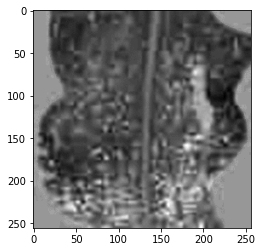

In [215]:
lab = cv2.cvtColor(smooth, cv2.COLOR_RGB2LAB)

a = lab[:, :, 1]

_, th = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
closing = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel = np.ones((5, 5)), iterations = 2)


plt.imshow(a, cmap = 'gray')

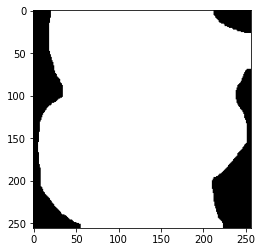

In [216]:
def extract_background(image):
    '''
    Perform k-means channel segmentation on the input mildew affected leaf.
    
    Inputs:
    image=> np.ndarray representation of the image. Background must be segmented
    mask=> mask for the leaf region on the image.
    
    returns:
    segment => segmentation result 
    '''
    im = image.copy()
    #convert to lab
    lab = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)

    #create a vector containing a*b* channel
    shape = lab.shape
    vector = lab[:, :, 1:]
    vector = vector.reshape(-1, 2)

    #convert to float32
    vector = np.float32(vector)

    #apply kmeans algorithm
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    K=3
    attempts=20
    _,label,center=cv2.kmeans(vector, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

    #get centroids
    center = np.uint8(center)
    res = center[label.flatten()]

    resArr = []
    #convert into an image with constant luminance
    for ele in res:
        a,b = ele[0], ele[1]
        resArr.append([90, a, b])
        
    resArr = np.array(resArr, dtype = np.uint8).reshape(shape)

    #segment automatically based on min a* value
    a_channel = resArr[:,:,1]
    
    maxVal = np.amax(a_channel)

    resImg = []

    #loop and apply thresholding
    for ele1 in resArr.reshape(-1,3):

        a = ele1[1]

        if a == maxVal:
            resImg.append([0])

        else:
            resImg.append([255])
            

    resImg = np.array(resImg, dtype = np.uint8).reshape(image.shape[:2])
    opening = cv2.morphologyEx(resImg, cv2.MORPH_OPEN, kernel = np.ones((5, 5)), iterations = 2)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel = np.ones((5, 5)), iterations = 2)
    cnts, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #fill contour for mask
    mask = np.ones(im.shape[:2], dtype="uint8") * 0
    mask = cv2.drawContours(mask, cnts, -1, (255), cv2.FILLED)
    return mask
mask = extract_background(smooth)

plt.imshow(mask, cmap = 'gray')

<h2> Extract leaf from mask </h2>

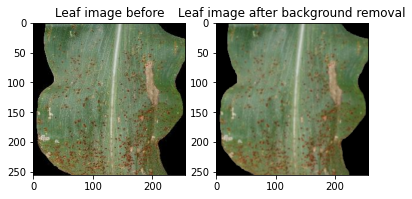

In [217]:
def use_mask(mask:np.ndarray, image:np.ndarray, invert:bool = False) -> np.ndarray:
    '''
    Perform and operation on input image and mask
    Inputs:
    mask => binary mask 
    image => np.ndarray representation of the image
    invert => boolean, if set to true, mask will be inverted before pixelwise & operation.
    Returns:
    resimage => np.ndarray representation of the and operation between mask and image.
    '''
    #if we want background
    if invert is True:
        mask = 255 - mask
        
    resimage = cv2.bitwise_and(image, image, mask = mask)
    resimage[mask == 0] = [0, 0, 0]
    return resimage

leaf_image = use_mask(mask, smooth)

fig, axs = plt.subplots(1, 2)
axs[1].set_title("Leaf image after background removal")
axs[1].imshow(leaf_image)
axs[0].set_title("Leaf image before")
axs[0].imshow(image)
plt.show()

<h2> Detection Starts </h2>

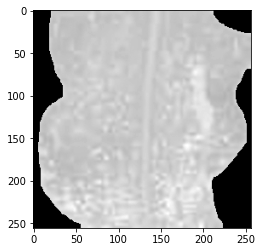

In [218]:
lab =  cv2.cvtColor(leaf_image, cv2.COLOR_RGB2LAB)
lab  = cv2.bitwise_and(lab, lab, mask = mask)
a = lab[:, :, 1]
plt.imshow(a, cmap = 'gray')

<h2> Contrast Stretching </h2>

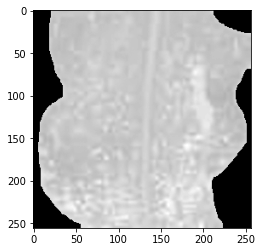

In [219]:
#contrats stretching
def stretch_contrast(image:np.ndarray) -> np.ndarray:
    '''
    Function to perform contrast stretching given an input image.
    
    Inputs =>
    image : numpy.ndarray representation of the image (must be only one channel)
    
    Returns =>
    con_image : min-max contrast stretched representation of the input image
    
    '''
    
    con_image = np.copy(image).reshape(-1)
    
    #min intensity
    min_i = np.amin(con_image)
    #max intensity
    max_i = np.amax(con_image)
    
    for idx, pixel in enumerate(con_image):
        
        con_image[idx] = 255 * ((pixel - min_i) / (max_i - min_i))
    
    #reshape and return
    con_image = con_image.reshape(image.shape)
    con_image = con_image.astype("uint8")
    
    return con_image

con_a = stretch_contrast(a)

plt.imshow(con_a, cmap = 'gray')

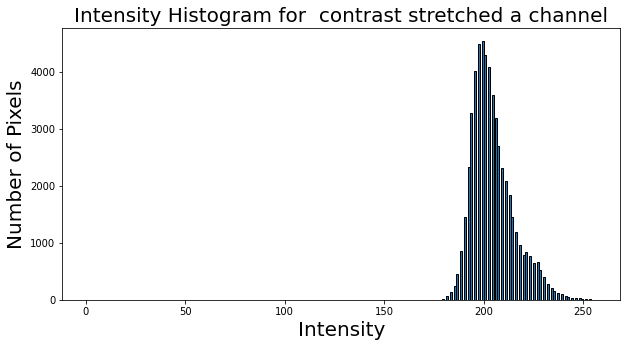

In [220]:
plt.figure(figsize = (10, 5))
plt.title("Intensity Histogram for  contrast stretched a channel", fontsize = 20)
plt.xlabel("Intensity", fontsize = 20)
plt.ylabel("Number of Pixels", fontsize = 20)
histo,bins,_= plt.hist(con_a.flat, bins=255, range=(1, 256),ec='black')
plt.show()

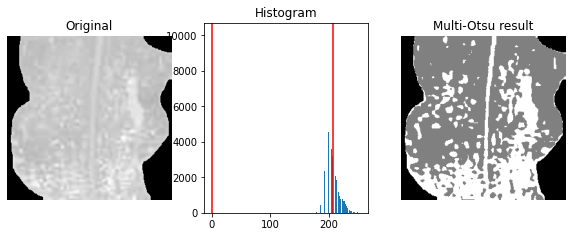

In [221]:
thresholds = threshold_multiotsu(con_a)

regions = np.digitize(con_a, bins=thresholds)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(con_a, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(con_a.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap = 'gray')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

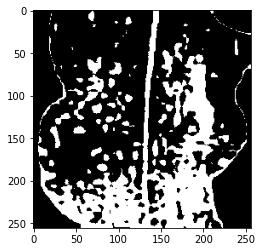

In [222]:
maxi = np.amax(regions)

resArr = []

for pix in regions.reshape(-1):
    if pix == maxi:
        resArr.append(255)
    else:
        resArr.append(0)
        
resArr = np.array(resArr, dtype = np.uint8).reshape(regions.shape)

# resArr = 255 - resArr

# resArr = cv2.bitwise_and(resArr, resArr, mask = mask)

plt.imshow(resArr, cmap = 'gray')

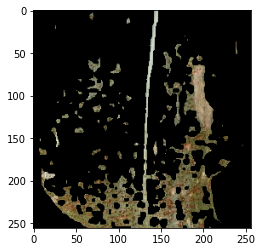

In [223]:
resArr = cv2.erode(resArr, kernel = np.ones((3, 3)), iterations = 1)
res = use_mask(resArr, image)

plt.imshow(res)

<h2> Method 2: Thresholding on the H channel</h2>

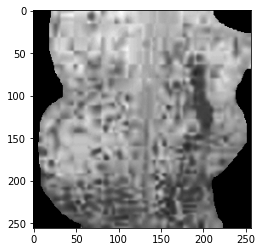

In [224]:
hsv =  cv2.cvtColor(leaf_image, cv2.COLOR_RGB2HSV)
hsv  = cv2.bitwise_and(hsv, hsv, mask = mask)
h = hsv[:, :, 0]
plt.imshow(h, cmap = 'gray')

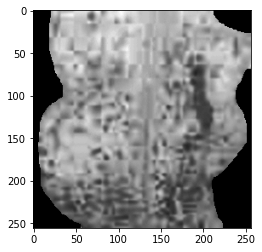

In [225]:
con_h = stretch_contrast(h)

plt.imshow(con_h, cmap = 'gray')

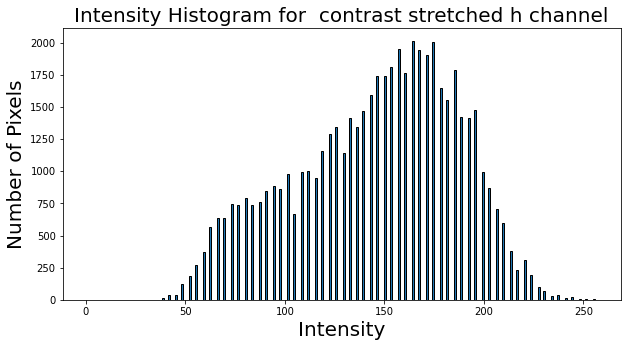

In [226]:
plt.figure(figsize = (10, 5))
plt.title("Intensity Histogram for  contrast stretched h channel", fontsize = 20)
plt.xlabel("Intensity", fontsize = 20)
plt.ylabel("Number of Pixels", fontsize = 20)
histo,bins,_= plt.hist(con_h.flat, bins=255, range=(1, 256),ec='black')
plt.show()

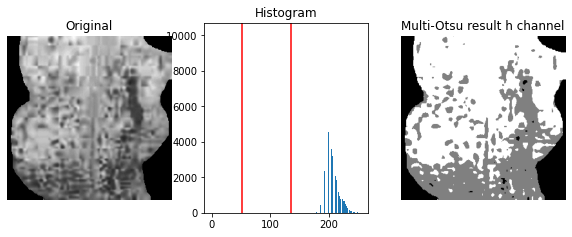

In [227]:
thresholds = threshold_multiotsu(con_h)

regions = np.digitize(con_h, bins=thresholds)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(con_h, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(con_a.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap = 'gray')
ax[2].set_title('Multi-Otsu result h channel')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

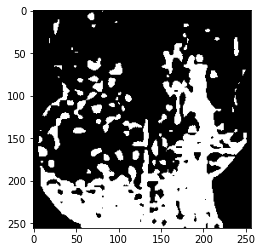

In [228]:
maxi = np.amax(regions)

resArr = []

for pix in regions.reshape(-1):
    if pix == maxi:
        resArr.append(255)
    else:
        resArr.append(0)
        
resArr = np.array(resArr, dtype = np.uint8).reshape(regions.shape)

resArr = 255 - resArr

resArr = cv2.bitwise_and(resArr, resArr, mask = mask)

plt.imshow(resArr, cmap = 'gray')

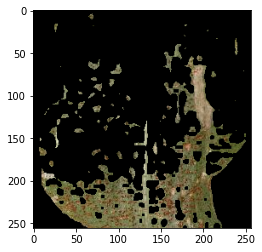

In [229]:
resArr = cv2.erode(resArr, kernel = np.ones((3, 3)), iterations = 1)

res = use_mask(resArr, image)

plt.imshow(res)

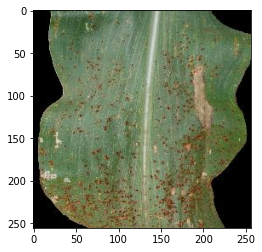

In [230]:
plt.imshow(image)

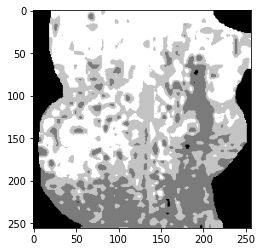

In [231]:
def k_means_cluster(leaf_image, leaf_mask, k_val):
    shape=leaf_image.shape
    lm = cv2.cvtColor(leaf_image, cv2.COLOR_RGB2HSV)
    vector=lm[:,:,0:1]
    vector=vector.reshape(-1,1)

    #convert to float32
    vector=np.float32(vector)

    #criteria
    criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30,1.0)
    K=k_val
    attempts=10
    ret,label,center=cv2.kmeans(vector,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)


    center=np.uint8(center)
    res=center[label.flatten()]

    resArr=[]
    for ele in res:
        h,s,v=ele[0],90,90
        resArr.append([h, s, v])
    resArr=np.array(resArr,dtype=np.uint8)
    resArr=resArr.reshape(shape)
    h_channel = resArr[:, :, 0]
    plt.imshow(h_channel, cmap  = 'gray')
    mask_s = []
    maxi = np.amax(h_channel)

    for pixel in h_channel.reshape(-1):
        if pixel == maxi:
            mask_s.append([0])
            continue
        mask_s.append([255])

    mask_s = np.array(mask_s, dtype = np.uint8).reshape(h_channel.shape)
    mask_s = cv2.bitwise_and(mask_s, mask_s, mask = leaf_mask)
    return mask_s

ms = k_means_cluster(leaf_image, mask, 4)
# plt.imshow(ms, cmap = 'gray')

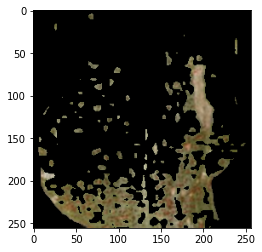

In [232]:
final = use_mask(ms, leaf_image)
ms2 = k_means_cluster(final, ms, 3)
plt.imshow(ms2, cmap = 'gray')
fms = use_mask(ms2, leaf_image)
plt.imshow(fms)

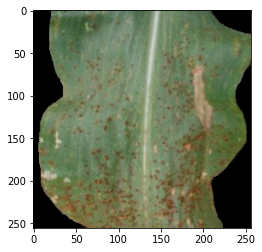

In [233]:
plt.imshow(leaf_image)